# Feature engineering : Prévision de production solaire à J+1 en temps réel

***Résumé Exécutif de l'Exploration de Données (EDA) - Prévision Solaire J+1***

Cette analyse exploratoire des données (EDA) vise à comprendre les caractéristiques de la production solaire régionale et des variables météorologiques associées, en préparation du développement d'un modèle de prévision à J+1.

**Données** : Dataset horaire sur 2.5 ans (01/2023 - 05/2025) de production RTE et prévisions OpenMétéo. Identification de 2 valeurs manquantes nocturnes dans la cible, qui seront imputées à 0.

**Variable Cible ("solar_mw")** :
- Forte saisonnalité journalière et annuelle, avec une dérive positive due à l'augmentation de la capacité installée ;
- Distribution asymétrique à droite, avec de nombreux zéros (nuit/mauvaises conditions) ; 
- Nécessite une différenciation saisonnière d'ordre 24 pour la stationnarité (confirmée par test ADFuller), avec un ordre AR de 1 (analyse PACF), et un ordre MA de q (à déterminer).

**Variables Explicatives (Covariables) :**
- Fortes corrélations (+0.8) avec la cible : global_tilted_irradiance, shortwave_radiation ;
- Redondances identifiées : Irradiance/Radiation (choix de l'irradiance pour le sens physique), température/température apparente (choix de temperature_2m) ;
- Variables de dispersion (delta_minmax, std) : Essentielles pour capturer l'hétérogénéité spatiale de la région, notamment pour la couverture nuageuse et la DNI ;
- Cross-corrélation : Déphasages clairs pour l'irradiance, l'humidité, la vitesse du vent et la température (justifiant des lags aux ordres 24, 36, 48...). Pression et couverture nuageuse non pertinentes pour les lags.

**Prochaines Étapes (déjà identifiées) dans ce notebook** :
- Feature Engineering (encodage cyclique, features laggées, agrégations).

**Prochaines étapes (déjà identifiées) ensuite** :
- Baseline SARIMAX avec les features physiques les plus corrélées ;
- Sélection de features (RFE ou Embedding via LightGBM) ;
- Validation croisée "Expanding Window" avec optimisation des hyperparamètres (Optuna) ;
- Développement de modèles LightGBM et LSTM, avec MC dropout et regression quantile pour quantifier l'incertitude des modèles

=================================================================================================================================================================================================

#### Contraintes métiers

- Les modèles ensemblistes et DL doivent avoir un temps d'inférence inférieur à la demi-heure, afin de proposer leurs résultats avant la livraison des résultats et en ayant le maximum d'informations possibles (12h) ; 
- **REMINDER TO MYSELF** : Eviter le data leakage sur les moyennes mobiles et les features temporelles ;

#### Analyse comparative modèle statistique linéaire paramétrique/ensembliste/NN

- Le choix d'utiliser le modèle SARIMAX, LightGBM et LSTM est motivé par l'interprétabilité proposé par les deux premiers modèles (Coefficients, Feature importance), avec précision accrue avec le modèle neuronal. Dans la suite des travaux, le modèle LSTM pourra être enrichi par un couche CNN ou un mécanisme d'attention.

#### Plan de configuration technique

- Pipeline reproductible ;
- Stratégie et gestion des données manquantes/outliers (discussions avec métiers, EDA n'a pas constaté d'outliers mais garde-fous conseillés) : Z-score et IQR-filter proposés (Isolation Forest non pertinente ici) ;
- **REMINDER TO MYSELF** : la gestion de drift, variance sera problématisé ultérieurement, mais à garder en tête lors de la création de ce fichier
- Train/test split par nested CV : 
  - Boucle externe Feature selection (RFE, Feature importance): expanding window cross validation (k=5) ;
    - Boucle interne : expanding window cross validation (k=3) ;
      - Optimisation des hyperparamètres par minimisation de l'AIC pour SARIMAX (trade-off complexité-prévision). On pourrait aussi proposer une analyse des p-value, mais à relativiser au regard du problème de p-hacking ;
      - Optimisation des hyperparamètres par Optuna pour les modèles LightGBM et LSTM (maximisation de la précision avec minimisation du temps d'entrainement).

=================================================================================================================================================================================================

***Résumé Exécutif du Feature Engineering - Prévision Solaire J+1***

L'étape de feature_engineering a consisté à la prise en compte des conclusions de l'analyse exploratoire (EDA), ainsi que la création de garde-fous données manquantes/outliers ainsi que la création de features cycliques et de variables laggées.

**Données** : Dataset horaire sur 2.5 ans (01/2023 - 05/2025) de production RTE et prévisions OpenMétéo. Identification de 2 valeurs manquantes nocturnes dans la cible, qui seront imputées à 0.

**Gardes-fous :**
- Création de tests IQR/Z-score et raise des outliers en intersection des deux filtres ;
- Interpolation des séquences temporelles inférieures à 3h consécutives ;
- Lors d'une absence de séquence de plus de 3 heures, création d'un reporting des séquences les plus longues, et potentiellement création d'un futur algorithme KNN - Filtre de Kalman.

**Features créées :**
- Création de features cycliques heures + mois, en fonction de la saisonnalité du cycle solaire ;
- Création de features laggées (data leakage évité): 
  - Retard de 24, 32 et 48 (observation des cross-correlation + cohérent physiquement) ;
  - Moyennes mobiles de 24, 32 et 48 périodes (analogue aux features retard).
 
**Etapes effectuées dans ce notebook** :

- Transformations statistiques pour les données LSTM et/ou SARIMAX si nécessaire ;
- Baseline SARIMAX avec les features physiques les plus corrélées ;
- Sélection de features (Embedding via LightGBM) ;
- Validation croisée "Expanding Window" avec optimisation des hyperparamètres (Optuna) ;
- Développement de modèles LightGBM et LSTM, avec MC dropout et regression quantile pour quantifier l'incertitude des modèles.

### Import des libraries

In [ ]:
# Base
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, Dict
import logging

# Modèles
import statsmodels.api as sm
from scipy.stats import jarque_bera, shapiro

In [2]:
# Confirmation d'être à la racine du dossier
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(project_root)

#### Importation des données

In [3]:
def import_data(path: str) -> pd.DataFrame :
    """Prends en entrée un link (path),  et retourne un dataset indexé temporellement
    Args:
        path (str): link vers les données d'entrainement
        run_filter (str): numéro du run central

    Returns:
        pd.DataFrame: Dataset préparatoire indexé temporellement, colonnes filtrées
    """

    df = pd.read_csv(path, sep=";", index_col=0)
    # Préparation du dataset post api
    df = df.rename(columns={"Solaire (MW)": "solar_mw"})
    df.index = pd.to_datetime(df.index, utc=True).tz_convert("Europe/Paris")
    df = df.resample('h').mean()

    return df

In [4]:
def col_scenario_rename(df: pd.DataFrame, run_filter: int) -> pd.DataFrame:
    """Retourne un dataframe avec les colonnes sans chiffre "_run_X"""
    
    df.columns = df.columns.str.replace(f"_run_{run_filter}", "")
    
    return df

In [5]:
def filter_covariable(df: pd.DataFrame, filter_col_list: list[str]) -> pd.DataFrame:

    return df[[col for col in df.columns if any(f in col for f in filter_col_list)]]

In [ ]:
central_scenario = 13 # Scénario barycentrique de toute la capacité solaire régionale
filter_col_list = ['solar_mw', 
                   'temperature_2m', 
                   'relative_humidity', 
                   "precipitation", 
                   "surface_pressure", 
                   "cloud_cover", 
                   "wind", 
                   "global_tilted_irradiance"]
df = import_data("data/processed/exploratory_solar_dataset.csv")
df = filter_covariable(df, filter_col_list)
df = col_scenario_rename(df, central_scenario)
df.head()

,solar_mw,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,global_tilted_irradiance,temperature_2m_delta_minmax,...,surface_pressure_delta_minmax,surface_pressure_std,cloud_cover_delta_minmax,cloud_cover_std,wind_speed_10m_delta_minmax,wind_speed_10m_std,wind_direction_10m_delta_minmax,wind_direction_10m_std,global_tilted_irradiance_delta_minmax,global_tilted_irradiance_std
2023-02-01 01:00:00+01:00,0.0,3.136,99.29538,0.0,974.73560,100.0,6.989936,304.50858,0.0,8.2125,...,77.1565,24.6962,97.0,33.9592,17.0646,5.1110,144.6560,44.3183,0.0,0.0
2023-02-01 02:00:00+01:00,0.0,3.436,99.64800,0.0,974.41766,100.0,8.089994,302.27563,0.0,8.3125,...,77.2900,24.7490,97.0,32.8282,17.0456,5.4139,148.8010,49.0035,0.0,0.0
2023-02-01 03:00:00+01:00,0.0,3.436,99.29709,0.0,974.41766,100.0,9.178235,281.30990,0.0,7.2125,...,77.0477,24.7034,69.0,26.3804,16.5235,5.2551,149.9315,44.3429,0.0,0.0
2023-02-01 04:00:00+01:00,0.0,3.436,98.59856,0.1,974.04000,100.0,9.693296,291.80148,0.0,6.1125,...,76.8325,24.6432,56.0,24.0376,16.8250,5.1948,337.0251,84.9825,0.0,0.0
2023-02-01 05:00:00+01:00,0.0,3.436,99.29709,0.6,974.04000,100.0,10.587918,305.31128,0.0,6.3125,...,76.8176,24.6293,71.0,24.1337,18.6071,5.4249,132.8228,38.0569,0.0,0.0


#### Gestion des outliers

l'EDA n'a pas montré d'outliers multivariés ou univariés. Une méthode simple de gestion des outliers sera donc univariés avec un double filtre z-score + IQR afin de déterminer des potentielles anomalies statistiques dans le jeu de données.

In [7]:
def iqr_range_filter(ts_series: pd.Series):
    """Retourne un filtre booléen des potentiels outliers de la série temporelle ts_series"""

    f_q = ts_series.quantile(0.25)
    t_q = ts_series.quantile(0.75)
    iqr = t_q - f_q

    ts_iqr_filter = (ts_series <= f_q-1.5*iqr) | (ts_series >= t_q+1.5*iqr)

    return ts_iqr_filter

In [8]:
def z_score_filter(ts_series: pd.Series):
    """Retourne un filtre booléen des potentiels outliers de la série temporelle ts_series"""
    
    z_score = (ts_series-ts_series.mean())/ts_series.std()

    ts_z_filter = (np.abs(z_score) > 3)

    return ts_z_filter

In [9]:
iqr_filter = iqr_range_filter(df["solar_mw"])
oz_score = z_score_filter(df["solar_mw"])

<Axes: xlabel='solar_mw', ylabel='Count'>

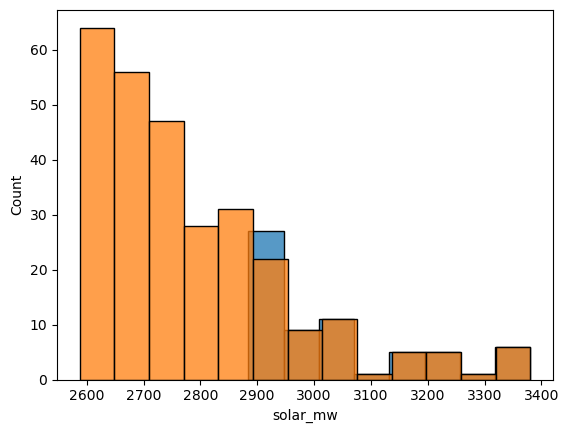

In [10]:
sns.histplot(df["solar_mw"][oz_score])
sns.histplot(df["solar_mw"][iqr_filter])

Nous pourrons noter dans la suite du travail comme outlier l'intersection des deux méthodes statistiques. Les outliers présents dans sur le graphe précédents sont explicables par les jours fortement ensoleillés, avec une augmentation progressive de la capacité des panneaux solaires (cf EDA).

#### Gestion des valeurs manquantes

L'EDA n'a pas montré de séquences longues absentes. Pour l'instant, il a été proposé de juste raise les potentielles séquences absentes de plus de 3 heures pour analyser la qualité des données d'entrée. Les séquences de moins de 3h absentes seront interpolées de manière linéaire en première approche, avec peut-être un lissage exponentiel dans le futur.

In [11]:
#ts = ts.interpolate("linear", limit=max_gap)

def missing_sequence_detection(ts: pd.Series, max_gap: int):
    """Détecte les séries temporelles manquantes de plus de max_gap (généralement 2 ou 3 heures)

    Args:
        df (pd.DataFrame): _description_
        max_gap (np.int8): _description_
    """
    dict_sequence = {}
    is_nan = ts.isna()
    start_sequence = is_nan & (~is_nan.shift(1, fill_value=False)) #Filtre les premiers index des séquences absentes
    sequence_number = 0 #ID de la séquence manquante

    for start_idx in ts[start_sequence].index:
        
        temp_idx = start_idx
        count = 0
        
        while temp_idx in ts.index and np.isnan(ts.loc[temp_idx]):
            count +=1
            next_idx = temp_idx + pd.Timedelta("1h")
            
            if next_idx in ts.index:
                temp_idx = next_idx
            else:
                raise(IndexError)
        
        end_idx = temp_idx - pd.Timedelta("1h") #Ajustement de l'id pour être le dernier de la séquence manquante
        sequence_number += 1
        
        if count > max_gap:
            logging.info(f"Séquence absente trouvée : {start_idx, end_idx}")
            dict_sequence[sequence_number] = [start_idx, end_idx]

    return dict_sequence

In [12]:
dict_sequence = missing_sequence_detection(df["solar_mw"], 3)
print(dict_sequence)

{}


La liste est vide car il n'y a pas d'outlier. Cette fonction sera utilisée dans le reporting en temps réel du pipeline data.

In [13]:
def interpolate_ts(df: pd.DataFrame) -> pd.DataFrame:
    """Interpole sur 3 heures maximum les colonnes du dataframe df de manière linéaire

    Args:
        df (pd.DataFrame): DataFrame d'entrée avec comme colonnes des séries temporelles

    Returns:
        pd.DataFrame: DataFrame de sortie avec interpolation sur valeurs absentes
    """
    for col in df.columns:
        df[col] = df[col].interpolate( method="linear", limit=3)

    return df

In [14]:
df = interpolate_ts(df)

#### Création des features temporelles

La création de features temporelles est primordiale pour des séries saisonnières telles que la production solaire. Les features brutes telles que les mois et les heures sont difficilement interprétables par les modèles linéaires et les réseaux de neurones. Ainsi, un encodage cyclique des mois et des heures (cos, sin), permet au modèle de d'intégrer d'une part la redondance des comportements, d'autre part la similarité du comportement de Décembre (12), et Janvier (0).

In [15]:
def cyclical_features_encoding(X: pd.DataFrame, timeframe_dict: Dict[str, int]) -> pd.DataFrame:
    
    """Encode les features cycliques dans un dataframe (df) muni d'un index temporel, par les features données dans le dictionnaire (timeframe_dict)

    Args:
        df (pd.DataFrame): DataFrame muni d'un TimeIndex
        timeframe_dict (dict): Dictionnaire muni du nom de la timeframe et de la saisonnalité associée : {"hour": 24}

    Returns:
        pd.DataFrame: DataFrame muni des colonnes temporelles cycliques (clé dictionnaire+"_cos", "clé dictionnaire"+"_sin")
    """
    df = X.copy()

    for key, item in timeframe_dict.items():
        
        df[key] =  getattr(df.index, key)
        df[f"{key}_sin"] = np.round(np.sin(2 * np.pi * df[key]/item), 5)
        df[f"{key}_cos"] = np.round(np.cos(2 * np.pi * df[key]/item), 5)

    df = df.drop(columns=list(timeframe_dict.keys()))

    return df

In [16]:
timeframe_dict = {"month":12, "hour":24}
df = cyclical_features_encoding(df, timeframe_dict)

In [17]:
df.head()

,solar_mw,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,global_tilted_irradiance,temperature_2m_delta_minmax,...,wind_speed_10m_delta_minmax,wind_speed_10m_std,wind_direction_10m_delta_minmax,wind_direction_10m_std,global_tilted_irradiance_delta_minmax,global_tilted_irradiance_std,month_sin,month_cos,hour_sin,hour_cos
2023-02-01 01:00:00+01:00,0.0,3.136,99.29538,0.0,974.73560,100.0,6.989936,304.50858,0.0,8.2125,...,17.0646,5.1110,144.6560,44.3183,0.0,0.0,0.86603,0.5,0.25882,0.96593
2023-02-01 02:00:00+01:00,0.0,3.436,99.64800,0.0,974.41766,100.0,8.089994,302.27563,0.0,8.3125,...,17.0456,5.4139,148.8010,49.0035,0.0,0.0,0.86603,0.5,0.50000,0.86603
2023-02-01 03:00:00+01:00,0.0,3.436,99.29709,0.0,974.41766,100.0,9.178235,281.30990,0.0,7.2125,...,16.5235,5.2551,149.9315,44.3429,0.0,0.0,0.86603,0.5,0.70711,0.70711
2023-02-01 04:00:00+01:00,0.0,3.436,98.59856,0.1,974.04000,100.0,9.693296,291.80148,0.0,6.1125,...,16.8250,5.1948,337.0251,84.9825,0.0,0.0,0.86603,0.5,0.86603,0.50000
2023-02-01 05:00:00+01:00,0.0,3.436,99.29709,0.6,974.04000,100.0,10.587918,305.31128,0.0,6.3125,...,18.6071,5.4249,132.8228,38.0569,0.0,0.0,0.86603,0.5,0.96593,0.25882


In [18]:
def lagged_ma_feature_encoding(df: pd.DataFrame, feature_list: list[str], lag_list: list[int]) -> pd.DataFrame:
    
    """Prends en entrée un DataFrame df indexée temporellement avec une liste de features (feature_list) et de lags (lag_list), et renvoie le dataframe df munie des features laggées et
    d'une moyenne mobile sur les mêmes lags.

    Args:
        df (pd.DataFrame): DataFrame indexé temporellement
        feature_list (list[str]): Features (noms de colonnes du dataframe) que l'on veut retarder ou lisser.
        lag_list (list[int]): Liste de lags à imputer

    Returns:
        pd.DataFrame: Retourne le DataFrame munie des features laggées et les moyennes mobiles associées
    """

    for col in feature_list:
        for lag in lag_list:
            #Feature laggée
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
            #Moyenne mobile sur lag période
            df[f"{col}_ma_{lag}"] = df[col].rolling(window=lag).mean()
    
    df = df.dropna()
    
    return df

In [19]:
# Lags irradiance, humidité, vitesse du vent et température
lag_list = [24, 32, 48]
feature_list =['global_tilted_irradiance',  'relative_humidity_2m', 'temperature_2m', 'wind_speed_10m']
df = lagged_ma_feature_encoding(df, feature_list, lag_list)

In [20]:
df.head()

,solar_mw,temperature_2m,relative_humidity_2m,precipitation,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,global_tilted_irradiance,temperature_2m_delta_minmax,...,temperature_2m_lag_32,temperature_2m_ma_32,temperature_2m_lag_48,temperature_2m_ma_48,wind_speed_10m_lag_24,wind_speed_10m_ma_24,wind_speed_10m_lag_32,wind_speed_10m_ma_32,wind_speed_10m_lag_48,wind_speed_10m_ma_48
2023-02-03 01:00:00+01:00,0.0,0.686,95.755350,0.0,977.92096,95.0,3.259939,173.65990,0.0,10.3730,...,5.786,1.750063,3.136,2.613083,9.686609,7.660895,15.459054,7.823155,6.989936,9.771854
2023-02-03 02:00:00+01:00,0.0,-0.564,98.912430,0.0,977.47500,58.0,2.902413,150.25520,0.0,9.9285,...,4.436,1.593813,3.436,2.529750,4.829907,7.580583,12.879752,7.511363,8.089994,9.663779
2023-02-03 03:00:00+01:00,0.0,-1.364,99.268974,0.0,977.30927,100.0,1.800000,126.86999,0.0,9.7285,...,2.936,1.459438,3.436,2.429750,4.379589,7.473100,10.009036,7.254831,9.178235,9.510066
2023-02-03 04:00:00+01:00,0.0,-1.264,99.269585,0.0,977.04694,100.0,0.720000,90.00000,0.0,10.1785,...,1.836,1.362563,3.436,2.331833,3.976330,7.337419,7.704336,7.036570,9.693296,9.323122
2023-02-03 05:00:00+01:00,0.0,-1.464,98.904350,0.0,976.91080,1.0,1.138420,108.43504,0.0,9.9840,...,1.336,1.275063,3.436,2.229750,4.320000,7.204854,7.568566,6.835628,10.587918,9.126258


In [30]:
# Enregistrement du dataset généré
df.to_csv("data/processed/df_engineered.csv")